# Conditional Denoising Diffusion Probabilistic Model
This is pretty much the same code as in denoising-diffusion-probabilistic-model.ipynb except that we add the capability to make the model conditional on some additional information (in this case on which of the two moons we want to sample from).
There is no code-sharing between the two notebooks to make both entirely self-contained.

The differences are highlighted in the text above code-blocks.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons

## Step 1: Generate synthetic data

We generate a simple synthetic data set using sklearn's `make_moons`-method.

In [17]:
rstate = np.random.RandomState(seed=1)
X, y = make_moons(n_samples=1000, noise=1e-1/2, random_state=rstate)

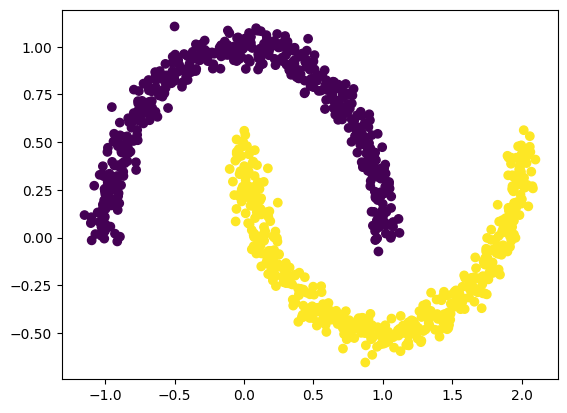

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Step 2: Time encoding module

We create a module for the sine-cosine time encoding, which will be used as part of our diffusion neural network in the next step.

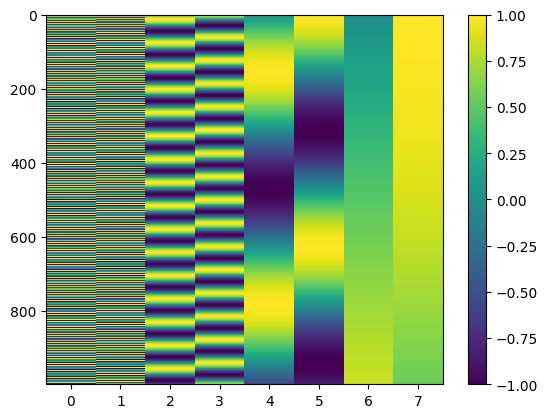

In [8]:
emb = torch.cat([torch.sin(torch.arange(1, 1000) / 10000**(2*0/8))[:, None], torch.cos(torch.arange(1, 1000) / 10000**(2*0/8))[:, None],
                 torch.sin(torch.arange(1, 1000) / 10000**(2*1/8))[:, None], torch.cos(torch.arange(1, 1000) / 10000**(2*1/8))[:, None],
                 torch.sin(torch.arange(1, 1000) / 10000**(2*2/8))[:, None], torch.cos(torch.arange(1, 1000) / 10000**(2*2/8))[:, None],
                 torch.sin(torch.arange(1, 1000) / 10000**(2*3/8))[:, None], torch.cos(torch.arange(1, 1000) / 10000**(2*3/8))[:, None]], dim=-1)
plt.imshow(emb.numpy(), aspect="auto", interpolation="nearest")
plt.colorbar()


In [9]:
class TimeEncoding(nn.Module):
    def __init__(self, num_dim):
        super(TimeEncoding, self).__init__()
        self.num_dim = num_dim

    def forward(self, t):
        dims = []
        for idx in range(self.num_dim // 2):
            dims.append(torch.sin(t / 10000**(2*idx/self.num_dim))[:, None])
            dims.append(torch.cos(t / 10000**(2*idx/self.num_dim))[:, None])
        return torch.cat(dims, dim=-1)


## Step 3: Implement Diffusion Neural Network

We implement a neural network module for performing the reverse diffusion step (i.e. going from noisier to less noisy). Unlike for images, our input size is relatively small, therefore we concatenate the time encoding rather than adding it on top. As in the original paper, we the time encoding is input in every layer of the neural network.

The model is the same as in `denoising-diffusion-probabilistic-model.ipynb` except for an additional input `c` that specifies the condition (in this case which of the two moons to sample from).

In [10]:
class DiffusionStepNetwork(nn.Module):
    def __init__(self, hidden_dim=16, condition_dim=1):
        super(DiffusionStepNetwork, self).__init__()
        self.time_encoder = TimeEncoding(num_dim=hidden_dim)

        self.fn1 = nn.Linear(2+hidden_dim+condition_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fn2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fn3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fn4 = nn.Linear(hidden_dim*2, 2)

    def forward(self, x, t, c):
        t_emb = self.time_encoder(t)
        c = torch.reshape(c, [-1, 1])

        h = torch.cat([x, t_emb, c], dim=-1)
        h = torch.cat([self.bn1(F.relu(self.fn1(h))), t_emb], dim=-1)
        h = torch.cat([self.bn2(F.relu(self.fn2(h))), t_emb], dim=-1)
        h = torch.cat([self.bn3(F.relu(self.fn3(h))), t_emb], dim=-1)
        h = self.fn4(h)
        return h

## Step 4: Train the diffusion model

We train the diffusion model as per Algorithm 1 in the paper. Each epoch uses a batch containing all training samples and we randomly sample time steps for each sample independently.

Again pretty much the same setup as in `denoising-diffusion-probabilistic-model.ipynb` except we provide the conditions as input, which here are provided by the labels of the two-moons data set.

0: 1.17632
500: 0.15481
1000: 0.13110
1500: 0.14232
2000: 0.14514
2500: 0.13403
3000: 0.12670
3500: 0.14748
4000: 0.13422
4500: 0.13746
5000: 0.13835
5500: 0.13417
6000: 0.15112
6500: 0.13637
7000: 0.12764
7500: 0.12819
8000: 0.14092
8500: 0.12561
9000: 0.14135
9500: 0.14739


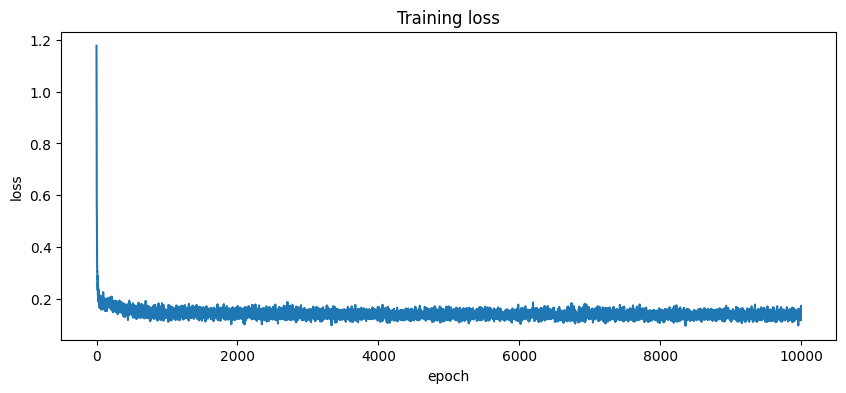

In [11]:
# Precomputing some constants
num_data, num_dims = X.shape
num_timesteps = 1000
betas = torch.from_numpy(np.linspace(start=1e-4, stop=0.02, num=num_timesteps)).float()
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

# Preparing model, optimizer, loss, and data
model = DiffusionStepNetwork(hidden_dim=128)
model = model.train()
loss_func = nn.MSELoss(reduction="mean")
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
X = torch.from_numpy(X).float() if isinstance(X, np.ndarray) else X.float()
c = torch.from_numpy(y.reshape([-1, 1])).float()

# Training loop
losses = []
for epoch in range(10**4):
    ts = rstate.randint(low=1, high=num_timesteps+1, size=num_data)
    epsilons = torch.from_numpy(rstate.randn(num_data, num_dims)).float()
    cur_alpha_bars = torch.tile(alpha_bars[ts-1][:, None], [1, num_dims])
    ts = torch.from_numpy(ts).float()

    input = torch.sqrt(cur_alpha_bars) * X + torch.sqrt(1.0 - cur_alpha_bars) * epsilons
    output = model(input, ts, c)
    loss = loss_func(output, epsilons)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
    if epoch % 500 == 0:
        print(f"{epoch}: {loss.cpu().detach().numpy():.5f}")

plt.figure(figsize=(10,4))
plt.title("Training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses)
plt.show()


## Step 5: Sample from the conditional diffusion model

We sample from the diffusion model as per Algorithm 2 in the paper.

The only difference to `denoising-diffusion-probabilistic-model.ipynb` is that we can also input a condition `c` along with the noise-sample, which allows specifying which moon to sample from.

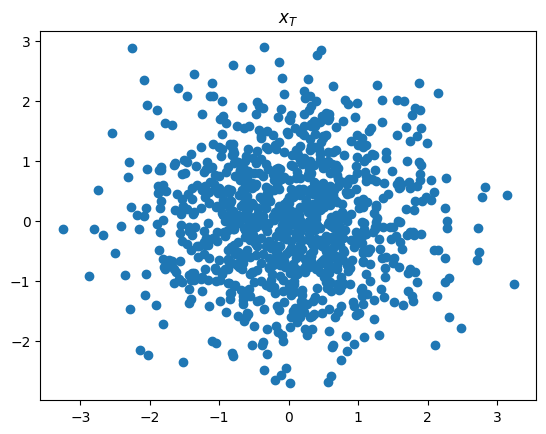

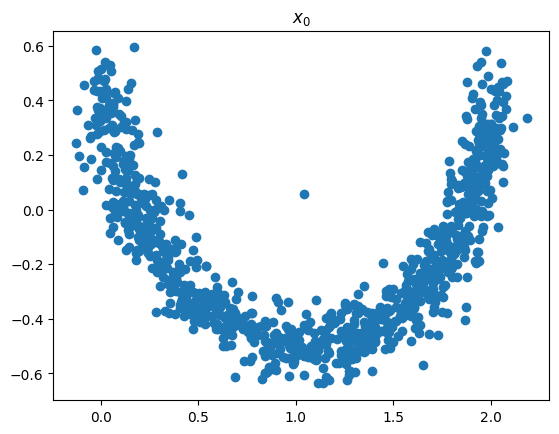

In [19]:
model = model.eval()
xt = torch.from_numpy(rstate.randn(num_data, num_dims)).float()
# Option 1: Sample equally many samples from both moons
# c = torch.from_numpy(np.concatenate([torch.zeros(num_data//2), torch.ones(num_data//2)], axis=0)).float()
# Option 2: Sample only from upper moon
# c = torch.zeros(num_data).float()
# Option 3: Sample only from lower moon
c = torch.ones(num_data).float()

# Plot before transforming samples
plt.title("$x_T$")
plt.scatter(xt.detach().numpy()[:, 0], xt.detach().numpy()[:, 1])
plt.show()

for t in reversed(range(1, num_timesteps)):
    z = torch.from_numpy(rstate.randn(num_data, num_dims)).float() if t > 1 else torch.zeros([num_data, num_dims])
    sigma_t = torch.sqrt(betas[t])
    t_tensor = torch.tile(torch.Tensor([t]).float(), [num_data])
    xt = (xt - (1 - alphas[t]) / torch.sqrt(1 - alpha_bars[t]) * model(xt, t_tensor, c)) / torch.sqrt(alphas[t]) + sigma_t * z
xt = xt.cpu().detach().numpy()

# Plot after transforming samples
plt.title("$x_0$")
plt.scatter(xt[:, 0], xt[:, 1])
plt.show()
